In [1]:
import logging
import os

working_dir = "/p/user_pub/climate_work/lee1043/cdat/pmp/mean_climate/mean_climate_workflow_refactorization/output/"

logging.basicConfig(filename=os.path.join(working_dir, 'error_log.txt'), level=logging.ERROR, filemode='w',
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [2]:
from pcmdi_metrics.mean_climate.lib_unified import (
    get_unique_bases, process_dataset, calculate_and_save_metrics, extract_info_from_model_catalogue, 
    get_ref_catalogue, get_model_catalogue, 
    multi_level_dict, print_dict, write_to_json
)
import os
import datetime


from pcmdi_metrics.utils import create_target_grid

In [3]:
variables = [
    #"pr", "ua-200", "ua-850", "va-200", "ta-850",
    "rsdt", "rsut", "rsutcs", "rlut", "rlutcs", 
    "rstcre", "rltcre", "rt", "rst"
]  # optional. If given, prioritized over the model_catalogue.json. If not given, use all variables commonly in ref_catalogue.json and model_catalogue.json

#variables = [
#    "ua-200", "ua-850", "va-200"
#]

variables = ["psl"]

model_data_path_template = "/home/data/%(model)/%(var)/%(model)_%(run)_%(var)_blabla.nc"  # optional. If given, prioritized over model_catalogue.json

models = ["model-a", "model-b"]  # optional. If given, prioritized over the model_catalogue.json. If not given, use all models in model_catalogue.json

models_runs_dict = {
    "model-a": ["r1", "r2"],
    "model-b": ["r1", "r2"],
    "model-c": ["r1", "r2"],
}
# optional. If given, prioritized over the model_catalogue.json. If not given, use all runs in model_catalogue.json

In [ ]:
interim_output_path_dict = { 
    "ref": {
        #"path_ac": "/p/user_pub/PCMDIobs/obs4MIPs_clims/%(var)/gn",
        #"path_ac_interp": "/p/user_pub/PCMDIobs/obs4MIPs_clims/%(var)/gr"
        "path_ac": "/p/user_pub/pmp/pmp_reference/obs4MIPs_clims/%(var)/gn",
        "path_ac_interp": "/p/user_pub/pmp/pmp_reference/obs4MIPs_clims/%(var)/gr"
        #"path_ac": "/p/user_pub/climate_work/lee1043/cdat/pmp/ACE_evaluation/clims_ref/%(var)/gn",
        #"path_ac_interp": "/p/user_pub/climate_work/lee1043/cdat/pmp/ACE_evaluation/clims_ref/%(var)/gr",
        #"path_ac": "/p/user_pub/climate_work/lee1043/cdat/pmp/mean_climate/mean_climate_workflow_refactorization/output/obs4MIPs_clims/%(var)/gn",
        #"path_ac_interp": "/p/user_pub/climate_work/lee1043/cdat/pmp/mean_climate/mean_climate_workflow_refactorization/output/obs4MIPs_clims/%(var)/gr"
    },
    "model": {
        "path_ac": "/p/user_pub/climate_work/lee1043/cdat/pmp/mean_climate/mean_climate_workflow_refactorization/output/clims_model/%(var)/gn",
        "path_ac_interp": "/p/user_pub/climate_work/lee1043/cdat/pmp/mean_climate/mean_climate_workflow_refactorization/output/clims_model/%(var)/gr"
    }
}

output_path = "/p/user_pub/climate_work/lee1043/temporary/mean_climate_workflow_refactorization/output/json"

regions = ["NHEX", "SHEX"]

target_grid = "2.5x2.5"

ref_catalogue_file_path = '/p/user_pub/PCMDIobs/catalogue/obs4MIPs_PCMDI_monthly_byVar_catalogue_v20250213.json'
model_catalogue_file_path = 'model_catalogue.json'

ref_data_head = "/p/user_pub/PCMDIobs"  # optional, if ref_catalogue file does not include entire directory path

In [5]:
rad_diagnostic_variables = ["rt", "rst", "rstcre", "rltcre"]

default_regions = ["global", "NHEX", "SHEX", "TROPICS"]

In [6]:
if not regions:
    regions = default_regions

In [7]:
refs_dict = get_ref_catalogue(ref_catalogue_file_path, ref_data_head)
models_dict = get_model_catalogue(model_catalogue_file_path, variables, models, models_runs_dict, model_data_path_template)

In [8]:
refs_dict

{'hfls': {'ERA-INT': {'obs4MIPs-template': 'obs4MIPs/ECMWF/ERA-INT/mon/hfls/gn/v20210727/hfls_mon_ERA-INT_PCMDI_gn_197901-201903.nc',
   'pcmdi-internal-template': '/p/user_pub/PCMDIobs/obs4MIPs/ECMWF/ERA-INT/mon/hfls/gn/v20210727/hfls_mon_ERA-INT_PCMDI_gn_197901-201903.nc',
   'period': '197901-201903',
   'path': '/p/user_pub/PCMDIobs/obs4MIPs/ECMWF/ERA-INT/mon/hfls/gn/v20210727',
   'filename': 'hfls_mon_ERA-INT_PCMDI_gn_197901-201903.nc',
   'template': '/p/user_pub/PCMDIobs/obs4MIPs/ECMWF/ERA-INT/mon/hfls/gn/v20210727/hfls_mon_ERA-INT_PCMDI_gn_197901-201903.nc'},
  'TropFlux-1-0': {'obs4MIPs-template': 'obs4MIPs/ESSO/TropFlux-1-0/mon/hfls/gn/v20210727/hfls_mon_TropFlux-1-0_PCMDI_gn_197901-201707.nc',
   'pcmdi-internal-template': '/p/user_pub/PCMDIobs/obs4MIPs/ESSO/TropFlux-1-0/mon/hfls/gn/v20210727/hfls_mon_TropFlux-1-0_PCMDI_gn_197901-201707.nc',
   'period': '197901-201707',
   'path': '/p/user_pub/PCMDIobs/obs4MIPs/ESSO/TropFlux-1-0/mon/hfls/gn/v20210727',
   'filename': 'hfls

In [9]:
if any(var is None for var in (variables, models, models_runs_dict)): 
    variables, models, models_runs_dict = extract_info_from_model_catalogue(variables, models, models_runs_dict, refs_dict, models_dict)

In [10]:
common_grid = create_target_grid(target_grid_resolution=target_grid)

variables_unique: ['hfls', 'hfns', 'hfss', 'hur', 'hus', 'pr', 'prw', 'psl', 'rlds', 'rldscs', 'rltcre', 'rlus', 'rlut', 'rlutcs', 'rsds', 'rsdscs', 'rsdt', 'rstcre', 'rsus', 'rsuscs', 'rsut', 'rsutcs', 'rt', 'sfcWind', 'ta', 'tas', 'tasmax', 'tasmin', 'tauu', 'tauv', 'ts', 'ua', 'uas', 'va', 'vas', 'zg', 'zos']
variables_level_dict: {'hfls': [None], 'hfns': [None], 'hfss': [None], 'hur': [None], 'hus': [None], 'pr': [None], 'prw': [None], 'psl': [None], 'rlds': [None], 'rldscs': [None], 'rltcre': [None], 'rlus': [None], 'rlut': [None], 'rlutcs': [None], 'rsds': [None], 'rsdscs': [None], 'rsdt': [None], 'rstcre': [None], 'rsus': [None], 'rsuscs': [None], 'rsut': [None], 'rsutcs': [None], 'rt': [None], 'sfcWind': [None], 'ta': [None], 'tas': [None], 'tasmax': [None], 'tasmin': [None], 'tauu': [None], 'tauv': [None], 'ts': [None], 'ua': [None], 'uas': [None], 'va': [None], 'vas': [None], 'zg': [None], 'zos': [None]}
version: v20250219
var: tas
levels: [None]
=== var, ref: tas, ERA-5
Proc

2025-02-19 11:17:20,797 [ERROR]: 2690008576.py(process_references:46) >> Error for tas ERA-5: local variable 'levels_to_plot' referenced before assignment


regrid done, ds_ac_interp[tas].shape: (12, 72, 144)
data_var, da.shape: tas (12, 72, 144)
Error logged for tas ERA-5
Error from process_references for tas ERA-5: local variable 'levels_to_plot' referenced before assignment
var: ta
levels: [None]
=== var, ref: ta, ERA-5
Processing data for: ERA-5
Processing ref dataset - varname: ta, data: ERA-5, path: /p/user_pub/PCMDIobs/obs4MIPs/ECMWF/ERA-40/mon/ta/gn/v20210727/ta_mon_ERA-40_PCMDI_gn_195709-200208.nc
ver: v20250219
ver: v20250219
get_annual_cycle, var: ta
data_path: /p/user_pub/PCMDIobs/obs4MIPs/ECMWF/ERA-40/mon/ta/gn/v20210727/ta_mon_ERA-40_PCMDI_gn_195709-200208.nc
out_path: /p/user_pub/pmp/pmp_reference/obs4MIPs_clims/ta/gn
outfilename_head: ta_mon_ERA-40_PCMDI_gn
outfilename_template: ta_mon_ERA-40_PCMDI_gn_%(start-yyyymm)-%(end-yyyymm)_%(season)_v20250219.nc
ver: v20250219
infilename: ta_mon_ERA-40_PCMDI_gn_195709-200208.nc
type(d): <class 'xarray.core.dataset.Dataset'>
atts: {'Conventions': 'CF-1.7 ODS-2.1', 'PreparationInfo': 

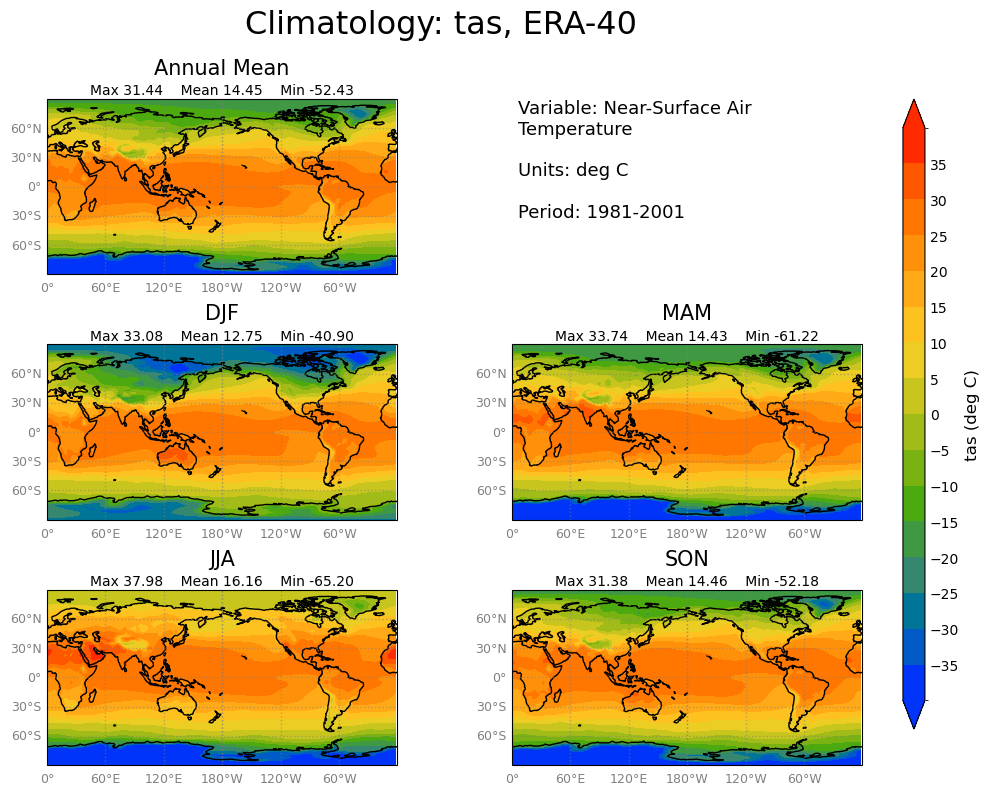

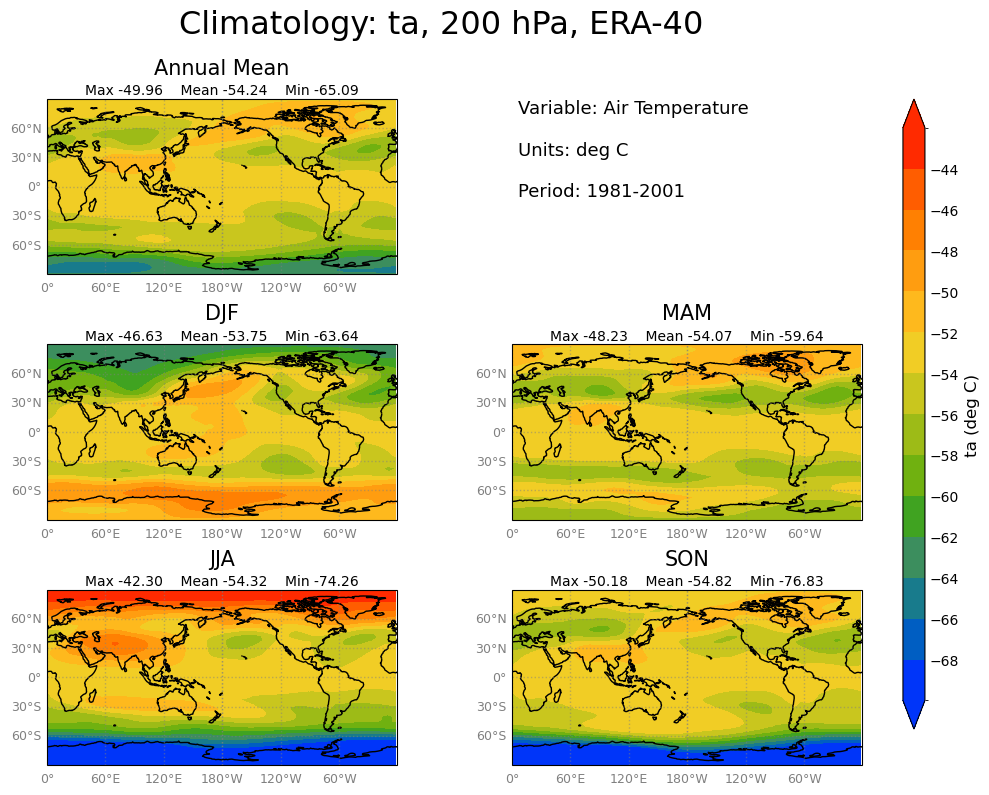

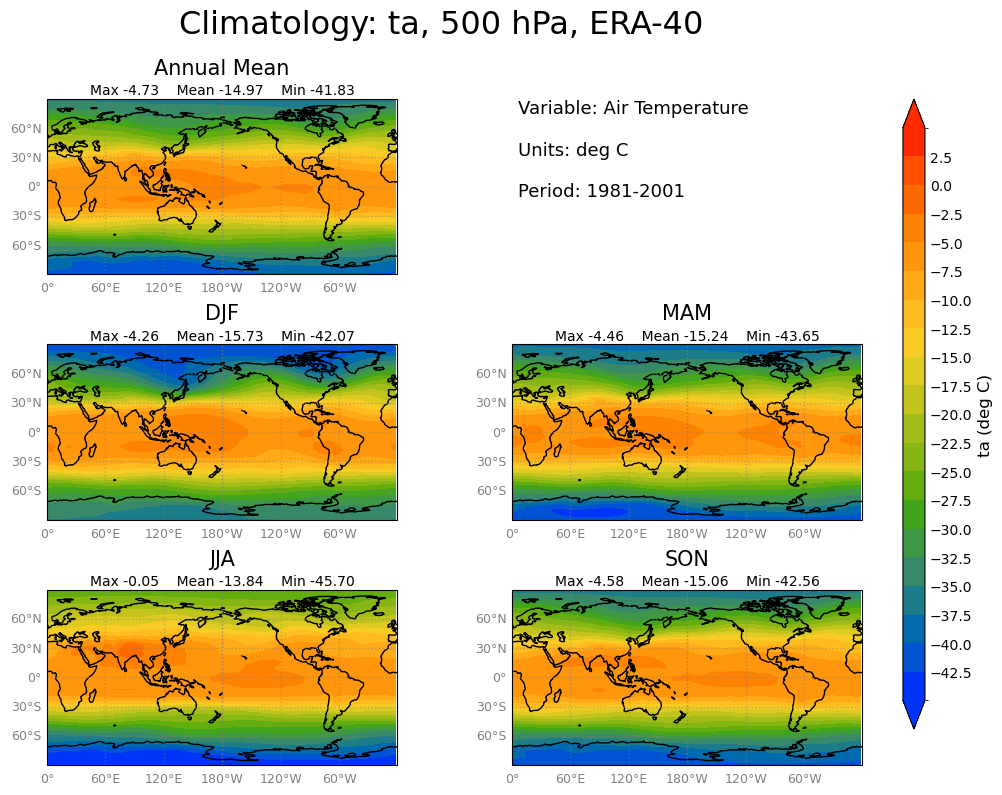

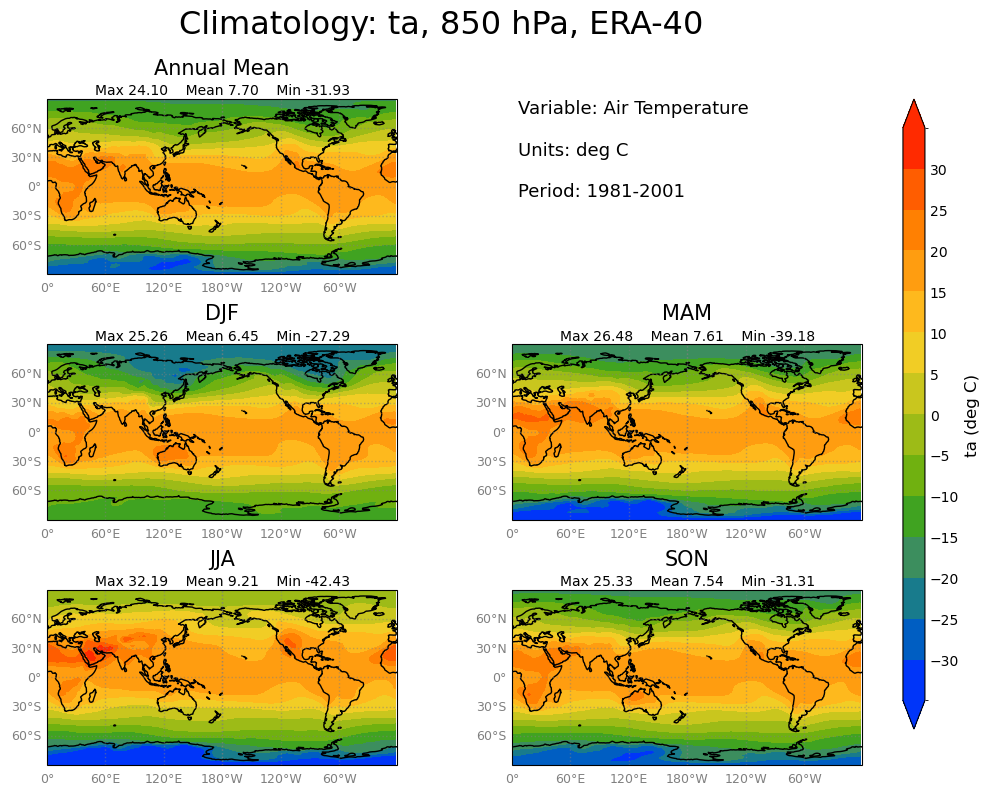

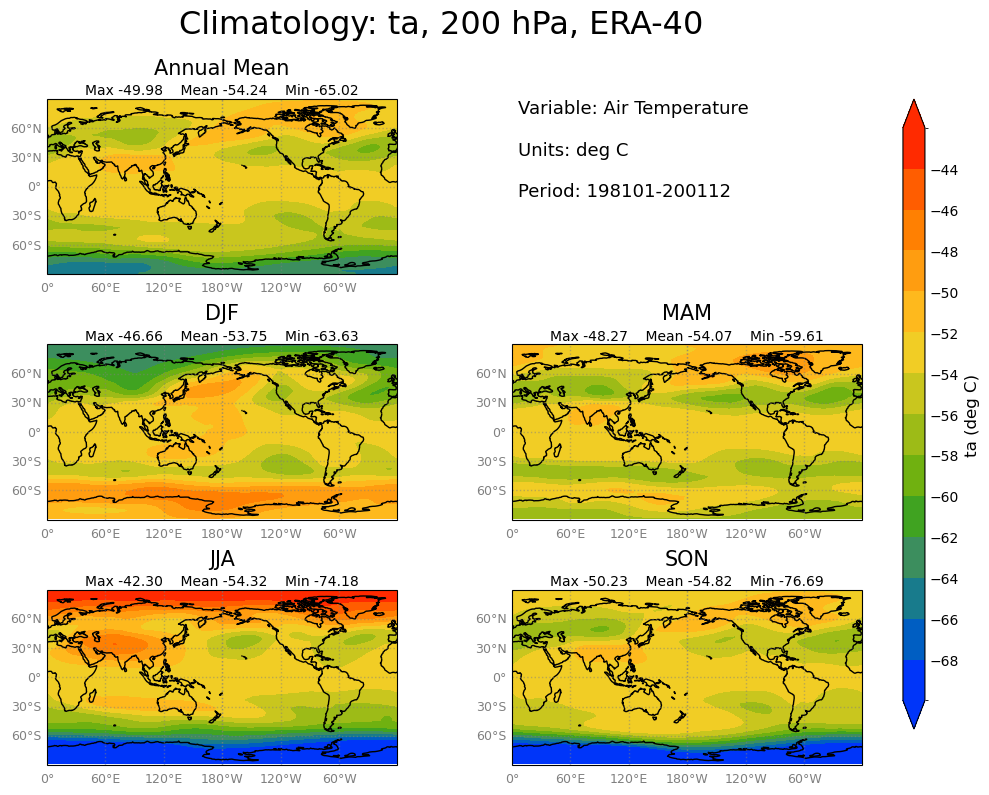

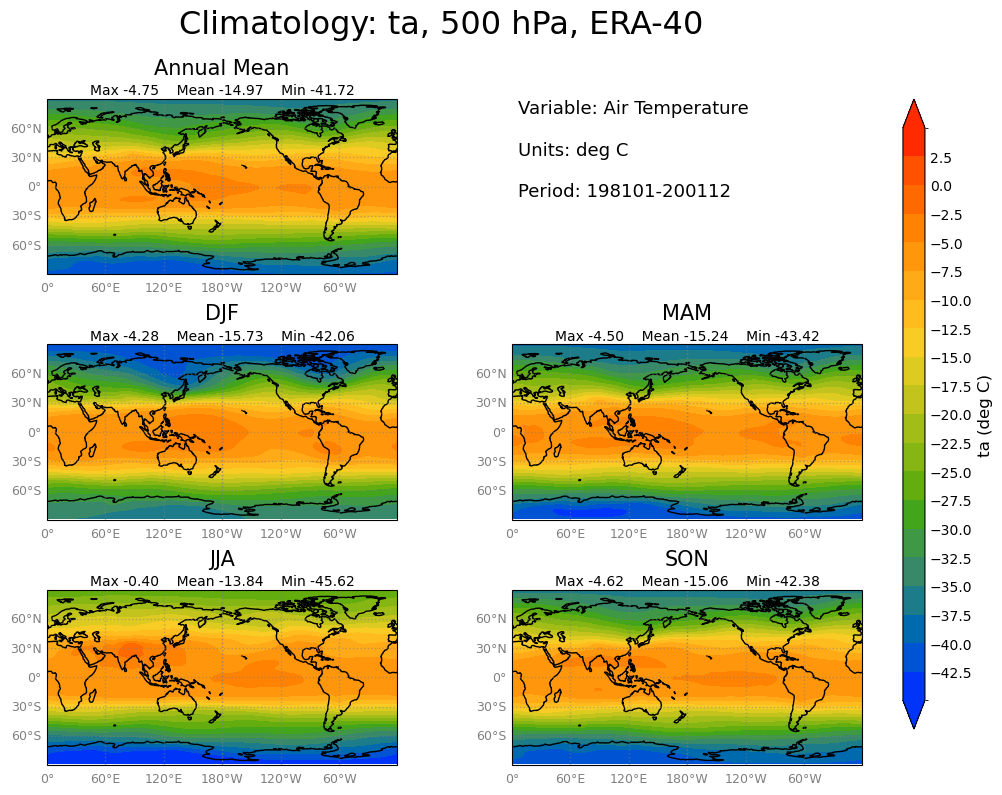

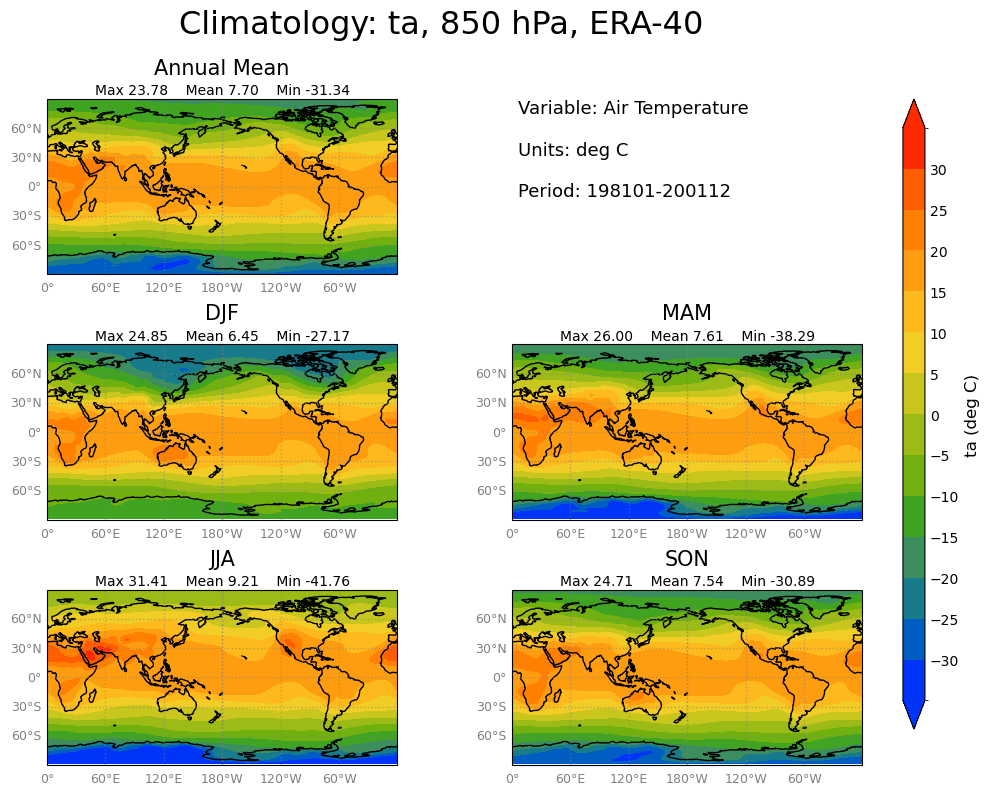

In [ ]:
encountered_variables = set()
ac_ref_dict = multi_level_dict()
ac_model_run_dict = multi_level_dict()
metrics_dict = multi_level_dict()



all_ref_variables = True

if all_ref_variables:
    variables = sorted(list(refs_dict.keys()))

variables_level_dict = get_unique_bases(variables)
variables_unique = list(variables_level_dict.keys())


#target_ref = None
#target_ref = "CERES-EBAF-4-2"
target_ref = "ERA-5"


#variables_unique = era5_vars
#refs_dict = grouped_files


print('variables_unique:', variables_unique)
print('variables_level_dict:', variables_level_dict)


def process_references(var, refs, rad_diagnostic_variables, levels, common_grid, start, end, version):
    for ref in refs:
        print(f"=== var, ref: {var}, {ref}")
        try:
        #if 1:
            process_dataset(
                var, ref, refs_dict, ac_ref_dict, rad_diagnostic_variables, 
                encountered_variables, levels, common_grid, interim_output_path_dict["ref"], data_type="ref",
                start=start, end=end,     
                repair_time_axis=True,
                overwrite_output_ac=True,
                version=version
            )
        
        except Exception as e:
            # Log the error to a file
            logging.error(f"Error for {var} {ref}: {str(e)}")
            print(f"Error logged for {var} {ref}")
            print(f'Error from process_references for {var} {ref}:', e)
        
        
def process_models(var, models, models_runs_dict, rad_diagnostic_variables, levels, common_grid, refs, start, end, version):
    for model in models:
        for run in models_runs_dict[model]:
            try:
                process_dataset(
                    var, (model, run), models_dict, ac_model_run_dict, 
                    rad_diagnostic_variables, encountered_variables, levels, common_grid, 
                    interim_output_path_dict["model"], data_type="model",
                    start=start, end=end,
                    version=version
                )
                for level in levels:
                    ac_model_run_level_interp = ac_model_run_dict[var][model][run][level]
                    calculate_and_save_metrics(var, model, run, level, regions, refs, ac_ref_dict, ac_model_run_level_interp, output_path, refs_dict, metrics_dict)
            except Exception as e:
                print(f'Error from process_models for {var} {model} {run}:', e)

    for level in levels:
        if level is None:
             var_key = var
        else:
             var_key = f"{var}-{level}"
        write_to_json(metrics_dict[var_key], os.path.join(output_path, f"output_{var_key}.json"))


def main():  
    # Set version identifier using the current date if not provided
    version = datetime.datetime.now().strftime("v%Y%m%d")
    print("version:", version)

    start = "1981-01"
    end = "2013-12"
    end = "2004-12"

    #variables_unique = ["pr"]
    #variables_unique = ["psl"]
    variables_unique = ["ta", "ua", "va", "zg"]
    #variables_unique = ["tas", "ta"]
    #variables_unique = ["ta"]

    for var in variables_unique:
        try:
            print("var:", var)
            encountered_variables.add(var)
            levels = variables_level_dict[var]

            print("levels:", levels)

            if var in refs_dict:
                refs = refs_dict[var].keys()

                if target_ref is not None:
                    if target_ref in refs:
                        refs = [target_ref]

                process_references(var, refs, rad_diagnostic_variables, levels, common_grid, start, end, version)

            # process_models(var, models, models_runs_dict, rad_diagnostic_variables, levels, common_grid, refs, start, end, version)
        
        except Exception as e:
            print(f'Error from main for {var}:', e)            
        
if __name__ == "__main__":
    main()


In [12]:
print_dict(refs_dict)

{
    "hfls": {
        "ERA-INT": {
            "filename": "hfls_mon_ERA-INT_PCMDI_gn_197901-201903.nc",
            "obs4MIPs-template": "obs4MIPs/ECMWF/ERA-INT/mon/hfls/gn/v20210727/hfls_mon_ERA-INT_PCMDI_gn_197901-201903.nc",
            "path": "/p/user_pub/PCMDIobs/obs4MIPs/ECMWF/ERA-INT/mon/hfls/gn/v20210727",
            "pcmdi-internal-template": "/p/user_pub/PCMDIobs/obs4MIPs/ECMWF/ERA-INT/mon/hfls/gn/v20210727/hfls_mon_ERA-INT_PCMDI_gn_197901-201903.nc",
            "period": "197901-201903",
            "template": "/p/user_pub/PCMDIobs/obs4MIPs/ECMWF/ERA-INT/mon/hfls/gn/v20210727/hfls_mon_ERA-INT_PCMDI_gn_197901-201903.nc"
        },
        "TropFlux-1-0": {
            "filename": "hfls_mon_TropFlux-1-0_PCMDI_gn_197901-201707.nc",
            "obs4MIPs-template": "obs4MIPs/ESSO/TropFlux-1-0/mon/hfls/gn/v20210727/hfls_mon_TropFlux-1-0_PCMDI_gn_197901-201707.nc",
            "path": "/p/user_pub/PCMDIobs/obs4MIPs/ESSO/TropFlux-1-0/mon/hfls/gn/v20210727",
            "pcmd

In [13]:
print_dict(models_dict)

{
    "psl": {
        "model-a": {
            "r1": {
                "filename": "model-a_r1_psl_blabla.nc",
                "path": "/home/data/model-a/psl",
                "template": "/home/data/model-a/psl/model-a_r1_psl_blabla.nc",
                "varname": "psl"
            },
            "r2": {
                "filename": "model-a_r2_psl_blabla.nc",
                "path": "/home/data/model-a/psl",
                "template": "/home/data/model-a/psl/model-a_r2_psl_blabla.nc",
                "varname": "psl"
            }
        },
        "model-b": {
            "r1": {
                "filename": "model-b_r1_psl_blabla.nc",
                "path": "/home/data/model-b/psl",
                "template": "/home/data/model-b/psl/model-b_r1_psl_blabla.nc",
                "varname": "psl"
            },
            "r2": {
                "filename": "model-b_r2_psl_blabla.nc",
                "path": "/home/data/model-b/psl",
                "template": "/home/data/model-b/